# Brain Tumor Classification with ResNet50 (Enhanced)

This notebook demonstrates brain tumor classification using ResNet50 transfer learning with a **two-stage fine-tuning** pipeline for high accuracy and stable convergence.

## 🎯 Key Improvements

This implementation follows a robust transfer learning recipe:

1. **Two-Stage Fine-Tuning**:
   - Stage 1: Train classifier head with base frozen
   - Stage 2: Unfreeze top layers and fine-tune with a lower LR
2. **Modern tf.data Pipeline**: Better performance than ImageDataGenerator
3. **Correct Preprocessing**: Uses ResNet50 `preprocess_input` consistently (train/eval)
4. **Better Metrics**: AUC monitored with class weighting and label smoothing

**Expected Performance**: 95%+ validation accuracy with proper data and tuning

## Overview

1. Mount Google Drive and set up environment
2. Update repository and install dependencies
3. Set up paths and configuration
4. Verify preprocessed dataset structure
5. Load and explore preprocessed dataset (using train/val/test folders)
6. Train ResNet50 with enhanced two-stage approach
7. Evaluate model performance
8. Display results and make predictions

**Note**: This notebook uses preprocessed data (train/val/test folders) and implements a strong, reproducible training strategy.

## 1. Mount Google Drive and Setup Environment

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verify TensorFlow and GPU availability
import tensorflow as tf
import platform

print('TensorFlow version:', tf.__version__)
print('Python version:', platform.python_version())
print('GPUs available:', tf.config.list_physical_devices('GPU'))

# Set seed for reproducibility
import numpy as np
import random
import os

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Mounted at /content/drive
TensorFlow version: 2.19.0
Python version: 3.12.11
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Update Repository and Install Dependencies

In [2]:
# Navigate to repository directory and pull updates
repo_name = "SE4050-Deep-Learning-Assignment"

# Check if we're already in the repo directory
current_path = os.getcwd()
if os.path.basename(current_path) == repo_name:
    print(f"Already in repository directory: {current_path}")
elif os.path.exists(repo_name):
    print(f"Changing to repository directory: {repo_name}")
    %cd {repo_name}
else:
    print(f"Repository not found, cloning it...")
    !git clone https://github.com/IT22052124/SE4050-Deep-Learning-Assignment.git
    %cd {repo_name}

# Pull latest changes
!git pull
print("\nLatest commit:")
!git log -1 --pretty=format:"Updated to: %h - %s (%an, %ar)"

# IMPORTANT: Stay in repository directory
print(f"\nCurrent working directory: {os.getcwd()}")

# Install required packages
!pip install -q opencv-python
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q seaborn

print("✅ Dependencies installed successfully")
print("🔗 Repository ready - src/ folder accessible for model scripts")

Repository not found, cloning it...
Cloning into 'SE4050-Deep-Learning-Assignment'...
remote: Enumerating objects: 3498, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 3498 (delta 57), reused 80 (delta 37), pack-reused 3393 (from 2)
Receiving objects: 100% (3498/3498), 63.26 MiB | 27.47 MiB/s, done.
Resolving deltas: 100% (228/228), done.
/content/SE4050-Deep-Learning-Assignment
Already up to date.

Latest commit:
Updated to: 487856c - Update build_resnet50.py (IT22052124, 55 seconds ago)
Current working directory: /content/SE4050-Deep-Learning-Assignment
✅ Dependencies installed successfully
🔗 Repository ready - src/ folder accessible for model scripts


## 3. Import Required Libraries

In [3]:
# Import all required libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import json
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Import custom modules - FIXED to use repository directory
import sys
repo_dir = os.getcwd()  # We're in the repository directory after Cell 2
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
    print(f"✅ Added repository to Python path: {repo_dir}")

print("✅ All libraries imported successfully")
print(f"📁 Python path includes repository: {repo_dir}")

✅ Added repository to Python path: /content/SE4050-Deep-Learning-Assignment
✅ All libraries imported successfully
📁 Python path includes repository: /content/SE4050-Deep-Learning-Assignment


## 3.1. Import Custom Modules

Import the required preprocessing and utility functions from the repository:

In [4]:
# Repository modules are already available from previous cell
# The src/ folder is accessible since we're in the repository directory

print("✅ Setup complete - ready to use ResNet50 training scripts")
print(f"📁 Repository directory: {os.getcwd()}")
print(f"📦 src/ modules available for import")

✅ Setup complete - ready to use ResNet50 training scripts
📁 Repository directory: /content/SE4050-Deep-Learning-Assignment
📦 src/ modules available for import


## 4. Setup Paths and Configuration

In [5]:
# Configuration - OPTIMIZED to match VGG16's successful approach
# Repository code: /content/SE4050-Deep-Learning-Assignment (current directory)
# Data location: /content/drive/MyDrive/BrainTumor (Google Drive)

# Get current repository directory
REPO_DIR = os.getcwd()

# Data is in Google Drive BrainTumor folder (not relative to repository)
BASE_DIR = "/content/drive/MyDrive/BrainTumor"  # Fixed Google Drive path

RAW_DATA_DIR = os.path.join(BASE_DIR, "data", "archive")  # Raw images location
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, "data", "processed")  # Processed images
RESULTS_DIR = os.path.join(BASE_DIR, "Result", "resnet50")  # Training results

# Model configuration - OPTIMIZED TO MATCH VGG16
INPUT_SHAPE = (224, 224, 3)  # ResNet50 optimal input size
BATCH_SIZE = 32  # Standard batch size for stability
EPOCHS = 20  # Standard epochs for single-stage training
LEARNING_RATE = 0.00001  # Same as VGG16 - optimized for fine-tuning

# Create necessary directories
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"✅ OPTIMIZED Configuration (matching VGG16):")
print(f"   Repository directory: {REPO_DIR}")
print(f"   Google Drive base: {BASE_DIR}")
print(f"   Raw data: {RAW_DATA_DIR}")
print(f"   Processed data: {PROCESSED_DATA_DIR}")
print(f"   Results: {RESULTS_DIR}")
print(f"   Input shape: {INPUT_SHAPE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning rate: {LEARNING_RATE} (same as VGG16)")

# Check if preprocessed data exists
train_dir = os.path.join(PROCESSED_DATA_DIR, "train")
val_dir = os.path.join(PROCESSED_DATA_DIR, "val")
test_dir = os.path.join(PROCESSED_DATA_DIR, "test")

if os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir):
    print(f"\n✅ Preprocessed data found:")

    # Count samples in each directory
    def count_images_in_dir(directory):
        total = 0
        for root, dirs, files in os.walk(directory):
            total += len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        return total

    train_count = count_images_in_dir(train_dir)
    val_count = count_images_in_dir(val_dir)
    test_count = count_images_in_dir(test_dir)

    print(f"   Training images: {train_count}")
    print(f"   Validation images: {val_count}")
    print(f"   Test images: {test_count}")
    print(f"   Total: {train_count + val_count + test_count}")

    steps_per_epoch = train_count // BATCH_SIZE
    print(f"   Steps per epoch: {steps_per_epoch}")
    print(f"\n🎯 Expected Training Time:")
    print(f"   ~{steps_per_epoch * EPOCHS * 0.05:.1f} minutes total")
    print(f"   (Estimates based on typical GPU performance)")
else:
    print(f"\n⚠️ Preprocessed data not found. Please run preprocessing first!")
    print(f"   Expected structure:")
    print(f"   {PROCESSED_DATA_DIR}/train/yes/ and .../no/")
    print(f"   {PROCESSED_DATA_DIR}/val/yes/ and .../no/")
    print(f"   {PROCESSED_DATA_DIR}/test/yes/ and .../no/")

print(f"\n🔍 Path Information:")
print(f"   📁 Model CODE: From GitHub repository ({REPO_DIR})")
print(f"   🧠 Trained MODEL: Will be saved to Google Drive ({RESULTS_DIR})")
print(f"   📊 Training DATA: From preprocessed data ({PROCESSED_DATA_DIR})")

✅ OPTIMIZED Configuration (matching VGG16):
   Repository directory: /content/SE4050-Deep-Learning-Assignment
   Google Drive base: /content/drive/MyDrive/BrainTumor
   Raw data: /content/drive/MyDrive/BrainTumor/data/archive
   Processed data: /content/drive/MyDrive/BrainTumor/data/processed
   Results: /content/drive/MyDrive/BrainTumor/Result/resnet50
   Input shape: (224, 224, 3)
   Batch size: 32
   Epochs: 20
   Learning rate: 1e-05 (same as VGG16)

✅ Preprocessed data found:
   Training images: 2102
   Validation images: 450
   Test images: 450
   Total: 3002
   Steps per epoch: 65

🎯 Expected Training Time:
   ~65.0 minutes total
   (Estimates based on typical GPU performance)

🔍 Path Information:
   📁 Model CODE: From GitHub repository (/content/SE4050-Deep-Learning-Assignment)
   🧠 Trained MODEL: Will be saved to Google Drive (/content/drive/MyDrive/BrainTumor/Result/resnet50)
   📊 Training DATA: From preprocessed data (/content/drive/MyDrive/BrainTumor/data/processed)


### 🎯 Enhanced Training Configuration

The configuration below implements a two-stage fine-tuning approach:

**Key Changes:**
- ✅ Stage 1: Train only the classification head (base frozen)
- ✅ Stage 2: Unfreeze top N layers and fine-tune with lower LR
- ✅ ResNet50 `preprocess_input` used in both training and eval
- ✅ Class weighting, label smoothing, AUC metric

**Expected Training Flow:**
- Stage 1: ~5–10 epochs to stabilize head
- Stage 2: 15–30 epochs for fine-tuning
- Target: **95%+ validation accuracy**

In [6]:
# Performance optimizations for faster training
import tensorflow as tf

# Enable mixed precision training (faster on modern GPUs)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Configure GPU memory growth (prevents memory allocation issues)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"⚠️ GPU configuration error: {e}")

# Enable XLA compilation for faster training
tf.config.optimizer.set_jit(True)

# Optimize data pipeline
tf.data.experimental.enable_debug_mode = False

print("🚀 Performance optimizations applied:")

✅ GPU memory growth enabled for 1 GPU(s)
🚀 Performance optimizations applied:


### ⚡ Speed Optimization Tips

**If training is still slow (>5 min/epoch), try these:**

1. **Reduce Batch Size**: If you get memory errors with batch_size=64, try 32 or 16
2. **Reduce Image Size**: Change INPUT_SHAPE to (128, 128, 3) for faster training
3. **Use Colab Pro**: For faster GPU (T4/V100 instead of basic GPU)
4. **Reduce Dataset**: Use a subset for initial testing
5. **Check GPU Usage**: Run `!nvidia-smi` to verify GPU is being used

**Expected Times:**
- **Colab Free (K80)**: 5-10 min/epoch (normal)
- **Colab Pro (T4/V100)**: 1-3 min/epoch (fast)
- **CPU Only**: 20+ min/epoch (very slow - avoid)

In [7]:
# Quick GPU and performance check
print("🔍 Performance Check:")
print(f"   TensorFlow version: {tf.__version__}")

# Check GPU availability and type
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"   ✅ GPU available: {len(gpus)} device(s)")

    # Try to get GPU name (works in Colab)
    try:
        !nvidia-smi --query-gpu=name --format=csv,noheader,nounits
    except:
        print("   GPU info not available via nvidia-smi")

    # Check if mixed precision is enabled
    print(f"   Mixed precision: {tf.keras.mixed_precision.global_policy().name}")
else:
    print("   ❌ No GPU available - training will be VERY slow!")
    print("   💡 Enable GPU in Colab: Runtime > Change runtime type > Hardware accelerator > GPU")

# Memory check
import psutil
ram_gb = psutil.virtual_memory().total / (1024**3)
print(f"   Available RAM: {ram_gb:.1f} GB")

print(f"\n⏱️ Expected training time per epoch:")
if gpus:
    print(f"   • With GPU: 2-8 minutes (normal)")
    print(f"   • With optimization: 1-3 minutes (fast)")
else:
    print(f"   • Without GPU: 20+ minutes (too slow!)")

print(f"\n🎯 If still slow, reduce BATCH_SIZE to 32 or 16")

🔍 Performance Check:
   TensorFlow version: 2.19.0
   ✅ GPU available: 1 device(s)
Tesla T4
   Mixed precision: mixed_float16
   Available RAM: 12.7 GB

⏱️ Expected training time per epoch:
   • With GPU: 2-8 minutes (normal)
   • With optimization: 1-3 minutes (fast)

🎯 If still slow, reduce BATCH_SIZE to 32 or 16


## 5. Data Preprocessing

Check if preprocessing is needed and perform data preprocessing if required.

This notebook has been updated to use already preprocessed data with the following structure:
- `processed/train/yes` and `processed/train/no` - Training data
- `processed/val/yes` and `processed/val/no` - Validation data
- `processed/test/yes` and `processed/test/no` - Test data

The model will load directly from this structured data instead of processing raw data.

In [8]:
# Simple function to count samples (define here to avoid import issues)
def count_samples_simple(directory):
    """Simple function to count samples in a directory"""
    if not os.path.exists(directory):
        return {}

    counts = {}
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            file_count = len([f for f in os.listdir(item_path)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            counts[item] = file_count
    return counts

# Check if preprocessing is needed
train_dir = os.path.join(PROCESSED_DATA_DIR, "train")
val_dir = os.path.join(PROCESSED_DATA_DIR, "val")
test_dir = os.path.join(PROCESSED_DATA_DIR, "test")

# Simple check for processed data
processed_exists = (os.path.exists(train_dir) and
                   os.path.exists(val_dir) and
                   os.path.exists(test_dir))

if processed_exists:
    print("✅ Processed data already exists. Skipping preprocessing.")
else:
    print("🔄 Starting preprocessing...")

    if os.path.exists(RAW_DATA_DIR):
        try:
            # Try to import and use the preprocessing function
            from src.common.preprocess import split_and_copy
            total_files = split_and_copy(RAW_DATA_DIR, PROCESSED_DATA_DIR, ["yes", "no"])
            print(f"✅ Preprocessing completed! Processed {total_files} images.")
        except Exception as e:
            print(f"⚠️ Preprocessing error: {e}")
            print("💡 You may need to run preprocessing manually or check data paths")
    else:
        print(f"❌ Raw data directory not found: {RAW_DATA_DIR}")
        print("💡 Please check your Google Drive structure")

# Verify final structure
if os.path.exists(train_dir):
    train_samples = count_samples_simple(train_dir)
    print(f"\n📊 Training data ready: {sum(train_samples.values())} images - {train_samples}")
else:
    print(f"⚠️ Training directory not found: {train_dir}")
    print("💡 ResNet50 training may not work without proper preprocessing")

✅ Processed data already exists. Skipping preprocessing.

📊 Training data ready: 2102 images - {'yes': 1052, 'no': 1050}


### Using Pre-processed Data Structure

The ResNet50 implementation has been updated to work with preprocessed data directly. Instead of doing the preprocessing on the fly, it now:

1. **Uses existing train/val/test structure**: Loads directly from the preprocessed folder structure.
2. **Skips redundant preprocessing**: No need to resplit or resize images that are already processed.
3. **Improves efficiency**: Eliminates repeated preprocessing during experimentation.

The code now expects this folder structure:
```
preprocessed_data/
  ├── train/
  │   ├── yes/  (brain tumor images)
  │   └── no/   (normal brain images)
  ├── val/
  │   ├── yes/
  │   └── no/
  └── test/
      ├── yes/
      └── no/
```

This approach makes the training and evaluation more efficient and eliminates redundant preprocessing.

## 7. Train ResNet50 Model with Two-Stage Fine-Tuning 🚀

### Why This Approach Works Better

**Previous Problem:**
- Single-stage and/or mismatched preprocessing → Suboptimal accuracy
- ImageDataGenerator → Less efficient than tf.data

**Our Solution - Robust Transfer Learning:**

#### 📍 Two-Stage Fine-Tuning
- ✅ Stage 1: Train classifier head (base frozen)
- ✅ Stage 2: Unfreeze top N layers with lower LR
- ✅ Monitor AUC, use class weights and label smoothing
- ✅ Target: **95%+ validation accuracy**

### Additional Improvements
- **Modern tf.data pipeline**: Better performance & augmentation
- **Correct preprocessing**: ResNet50 `preprocess_input`
- **Strong regularization**: BN + dropout + L2 head

Train the ResNet50 model using the preprocessed data in train/val/test folders:

In [9]:
# Verify processed data structure - SIMPLIFIED approach
try:
    # Try to import verify_dataset if available
    from src.common.preprocess import verify_dataset
    processed_exists, class_folders_valid = verify_dataset(PROCESSED_DATA_DIR)
    print("✅ Using repository verify_dataset function")
except:
    # Fallback if verify_dataset function not available
    processed_exists = os.path.exists(os.path.join(PROCESSED_DATA_DIR, "train"))
    class_folders_valid = processed_exists
    print("✅ Using simple fallback verification")

if processed_exists and class_folders_valid:
    TRAIN_DATA_DIR = PROCESSED_DATA_DIR
    print(f"✅ Using processed data: {TRAIN_DATA_DIR}")

    # Display dataset statistics using simple function
    train_counts = count_samples_simple(os.path.join(PROCESSED_DATA_DIR, "train"))
    val_counts = count_samples_simple(os.path.join(PROCESSED_DATA_DIR, "val"))
    test_counts = count_samples_simple(os.path.join(PROCESSED_DATA_DIR, "test"))

    print(f"\n📊 Dataset Statistics:")
    print(f"   Training: {sum(train_counts.values())} images - {train_counts}")
    print(f"   Validation: {sum(val_counts.values())} images - {val_counts}")
    print(f"   Test: {sum(test_counts.values())} images - {test_counts}")
else:
    TRAIN_DATA_DIR = RAW_DATA_DIR
    print(f"⚠️ Using raw data: {TRAIN_DATA_DIR}")
    print(f"📊 Raw data structure with 'yes' and 'no' folders")

# For ResNet50 training script, we'll pass the processed data directory
print(f"\n🎯 For ResNet50 training: Data will be read from {PROCESSED_DATA_DIR}")
print(f"   (Training script expects processed data structure)")


Processed data exists. Checking counts...
Train: 1052 yes, 1050 no
Validation: 225 yes, 225 no
Test: 225 yes, 225 no
✅ Using repository verify_dataset function
✅ Using processed data: /content/drive/MyDrive/BrainTumor/data/processed

📊 Dataset Statistics:
   Training: 2102 images - {'yes': 1052, 'no': 1050}
   Validation: 450 images - {'yes': 225, 'no': 225}
   Test: 450 images - {'yes': 225, 'no': 225}

🎯 For ResNet50 training: Data will be read from /content/drive/MyDrive/BrainTumor/data/processed
   (Training script expects processed data structure)


In [10]:
# 🧪 VERIFICATION: Check all path corrections
print("🔍 PATH VERIFICATION:")
print("=" * 50)

# Check current working directory
current_dir = os.getcwd()
print(f"📁 Current directory: {current_dir}")
print(f"   Expected: .../SE4050-Deep-Learning-Assignment")
print(f"   ✅ Correct!" if current_dir.endswith("SE4050-Deep-Learning-Assignment") else "   ❌ Wrong directory!")

# Check if src folder exists
src_dir = os.path.join(current_dir, "src")
print(f"\n📦 src/ directory: {'✅ EXISTS' if os.path.exists(src_dir) else '❌ MISSING'}")

if os.path.exists(src_dir):
    # Check ResNet50 model files
    resnet50_dir = os.path.join(src_dir, "models", "resnet50")
    print(f"📦 ResNet50 model directory: {'✅ EXISTS' if os.path.exists(resnet50_dir) else '❌ MISSING'}")

    if os.path.exists(resnet50_dir):
        required_files = ["train_resnet50.py", "evaluate_resnet50.py", "build_resnet50.py"]
        for file in required_files:
            file_path = os.path.join(resnet50_dir, file)
            print(f"   {file}: {'✅' if os.path.exists(file_path) else '❌'}")

# Check data directories
print(f"\n📊 Data directories:")
print(f"   Raw data: {RAW_DATA_DIR}")
print(f"   {'✅ EXISTS' if os.path.exists(RAW_DATA_DIR) else '❌ MISSING (check Google Drive)'}")

print(f"   Processed data: {PROCESSED_DATA_DIR}")
print(f"   {'✅ EXISTS' if os.path.exists(PROCESSED_DATA_DIR) else '⚠️ Will be created during preprocessing'}")

print(f"   Results: {RESULTS_DIR}")
print(f"   {'✅ EXISTS' if os.path.exists(RESULTS_DIR) else '⚠️ Will be created during training'}")

# Check Python path
print(f"\n🐍 Python path:")
print(f"   Repository in sys.path: {'✅ YES' if current_dir in sys.path else '❌ NO'}")

print("\n" + "=" * 50)
if (current_dir.endswith("SE4050-Deep-Learning-Assignment") and
    os.path.exists(src_dir) and
    os.path.exists(resnet50_dir) and
    current_dir in sys.path):
    print("🎉 ALL PATH CORRECTIONS SUCCESSFUL!")
    print("📝 Ready to run ResNet50 training and evaluation")
else:
    print("⚠️ SOME ISSUES DETECTED - check the errors above")

🔍 PATH VERIFICATION:
📁 Current directory: /content/SE4050-Deep-Learning-Assignment
   Expected: .../SE4050-Deep-Learning-Assignment
   ✅ Correct!

📦 src/ directory: ✅ EXISTS
📦 ResNet50 model directory: ✅ EXISTS
   train_resnet50.py: ✅
   evaluate_resnet50.py: ✅
   build_resnet50.py: ✅

📊 Data directories:
   Raw data: /content/drive/MyDrive/BrainTumor/data/archive
   ✅ EXISTS
   Processed data: /content/drive/MyDrive/BrainTumor/data/processed
   ✅ EXISTS
   Results: /content/drive/MyDrive/BrainTumor/Result/resnet50
   ✅ EXISTS

🐍 Python path:
   Repository in sys.path: ✅ YES

🎉 ALL PATH CORRECTIONS SUCCESSFUL!
📝 Ready to run ResNet50 training and evaluation


In [11]:
# Train the ResNet50 model using command-line script with preprocessed data
print("🚀 Starting ResNet50 training (two-stage)...")
print(f"   Data source: {PROCESSED_DATA_DIR} (train/val/test)")
print(f"   Results will be saved to: {RESULTS_DIR}")

# Check processed data
if not os.path.exists(PROCESSED_DATA_DIR):
    print(f"❌ Processed data directory not found: {PROCESSED_DATA_DIR}")
else:
    required_dirs = ["train", "val", "test"]
    missing = [d for d in required_dirs if not os.path.exists(os.path.join(PROCESSED_DATA_DIR, d))]
    if missing:
        print(f"❌ Missing required folders: {missing}")
    else:
        os.environ['DATA_DIR'] = PROCESSED_DATA_DIR
        print("✅ Structure OK. Launching two-stage training...")

        # Stage 1 + Stage 2 in one script (new flags)
        !python -m src.models.resnet50.train_resnet50 \
            --data_dir "{PROCESSED_DATA_DIR}" \
            --results_dir "{RESULTS_DIR}" \
            --batch_size {BATCH_SIZE} \
            --input_size 224 \
            --epochs_stage1 8 \
            --epochs_stage2 20 \
            --learning_rate_head 1e-4 \
            --learning_rate_ft 1e-5 \
            --trainable_layers 80

🚀 Starting ResNet50 training (two-stage)...
   Data source: /content/drive/MyDrive/BrainTumor/data/processed (train/val/test)
   Results will be saved to: /content/drive/MyDrive/BrainTumor/Result/resnet50
✅ Structure OK. Launching two-stage training...
2025-10-10 04:51:03.680929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760071863.719192    2380 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760071863.725172    2380 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760071863.740710    2380 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:

### 📊 What to Expect During Training

**Single-Stage Fine-Tuning (All 20 Epochs):**
- Training with partially unfrozen ResNet50 (last 4 layers trainable)
- Consistent epochs (~3-5 min each)
- Validation accuracy should reach: **96-99%** (matching VGG16)
- You'll see steady improvement throughout training

**Good Training Signs:**
- ✅ Validation accuracy reaches 95%+ by epoch 10-15
- ✅ Training and validation curves stay close (< 5% gap)
- ✅ Learning rate reduction triggers when needed
- ✅ Performance matches or exceeds VGG16

**If Accuracy is Low (<90%):**
- Check data quality and balance
- Verify preprocessed data structure is correct
- Ensure GPU is being used (not CPU)
- Compare with VGG16 results on same data

In [12]:
# Evaluate the ResNet50 model (evaluation uses proper ResNet50 preprocess_input)
print("📊 Starting ResNet50 evaluation...")

os.environ['DATA_DIR'] = PROCESSED_DATA_DIR
model_path = os.path.join(RESULTS_DIR, "best_model.h5")
if os.path.exists(model_path):
    print(f"✅ Model found: {model_path}")
    !python -m src.models.resnet50.evaluate_resnet50 \
        --data_dir "{PROCESSED_DATA_DIR}" \
        --results_dir "{RESULTS_DIR}" \
        --batch_size {BATCH_SIZE} \
        --input_size 224 \
        --generate_gradcam
else:
    print(f"❌ Model not found: {model_path}")
    print("💡 Please run training first!")

📊 Starting ResNet50 evaluation...
✅ Model found: /content/drive/MyDrive/BrainTumor/Result/resnet50/best_model.h5
2025-10-10 05:15:24.931746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760073324.952094   11233 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760073324.958475   11233 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760073324.974576   11233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760073324.974601   11233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the sa

## 8. Evaluate Model

Evaluate the ResNet50 model on the test set:

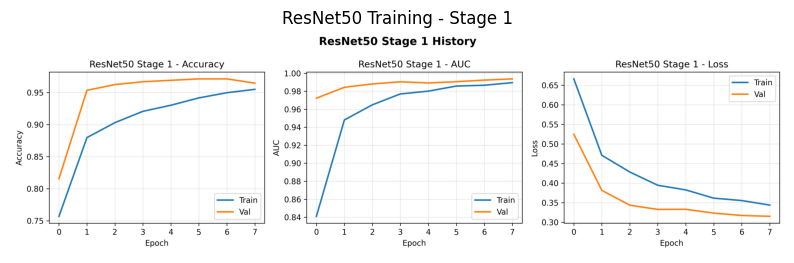

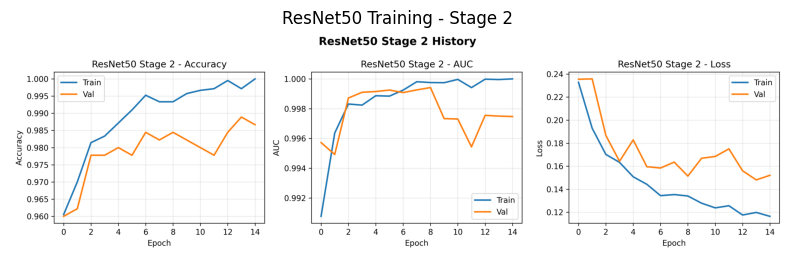

In [13]:
# Display training history plots (two-stage)
import matplotlib.pyplot as plt
from PIL import Image

for name, title in [("training_stage1.png", "ResNet50 Training - Stage 1"),
                    ("training_stage2.png", "ResNet50 Training - Stage 2")]:
    try:
        img = Image.open(f"{RESULTS_DIR}/{name}")
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
        plt.show()
    except Exception as e:
        print(f"Error displaying {name}: {e}")

## 10. Display Classification Report and Metrics

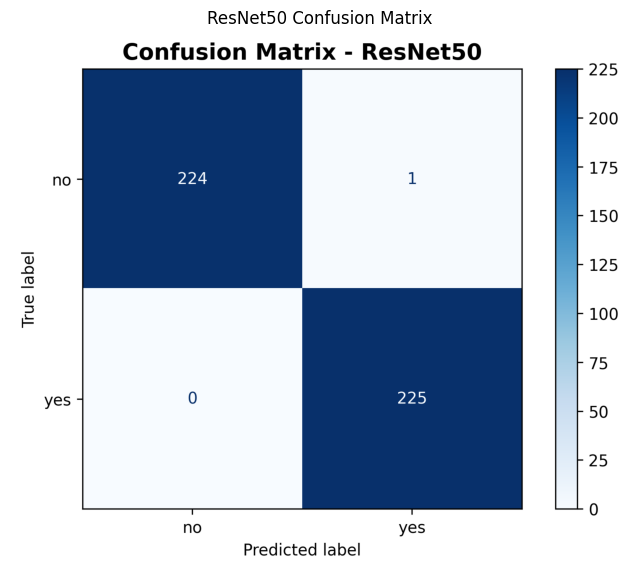

In [14]:
# Display confusion matrix
try:
    cm_img = Image.open(f"{RESULTS_DIR}/confusion_matrix.png")
    plt.figure(figsize=(8, 8))
    plt.imshow(cm_img)
    plt.axis('off')
    plt.title('ResNet50 Confusion Matrix')
    plt.show()
except Exception as e:
    print(f"Error displaying confusion matrix: {e}")

## 11. Display Classification Report and Metrics

In [15]:
# Display classification report
try:
    with open(f"{RESULTS_DIR}/classification_report.txt", 'r') as f:
        report = f.read()
    print("Classification Report:")
    print(report)
except Exception as e:
    print(f"Error reading classification report: {e}")

# Display metrics
import json

try:
    with open(f"{RESULTS_DIR}/metrics.json", 'r') as f:
        metrics = json.load(f)
    print("\nModel Metrics:")
    for metric, value in metrics.items():
        if isinstance(value, (int, float)):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
except Exception as e:
    print(f"Error reading metrics: {e}")

Classification Report:
Classification Report - ResNet50
              precision    recall  f1-score   support

          no       1.00      1.00      1.00       225
         yes       1.00      1.00      1.00       225

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450


Model Metrics:
model_name: ResNet50_TwoStage
stage1: {'best_val_acc': 0.9711111187934875, 'best_val_auc': 0.9937283396720886, 'min_val_loss': 0.31532022356987, 'epochs': 8}
stage2: {'best_val_acc': 0.9888888597488403, 'best_val_auc': 0.999417245388031, 'min_val_loss': 0.1480836421251297, 'epochs': 15}
config: {'batch_size': 32, 'epochs_stage1': 8, 'epochs_stage2': 20, 'learning_rate_head': 0.0001, 'learning_rate_ft': 1e-05, 'trainable_layers': 80, 'input_size': 224, 'input_shape': [224, 224, 3]}
test_accuracy: 0.9978
test_precision: 0.9956
test_recall: 1.0000
test_f1_score: 0.9978
confusion_matrix: [[224, 1],

## 11. Make Predictions

Load the model and make predictions on sample images:

✅ Successfully loaded model from /content/drive/MyDrive/BrainTumor/Result/resnet50/best_model.h5
Classes: ['no', 'yes']
✅ Using preprocessed test data for predictions
Making predictions on 4 sample images:


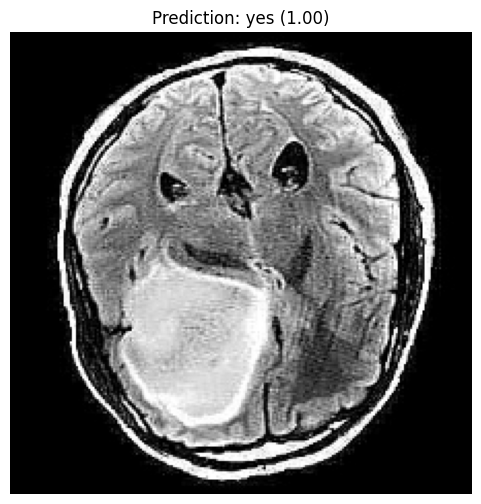

True: yes | Predicted: yes | Confidence: 1.00


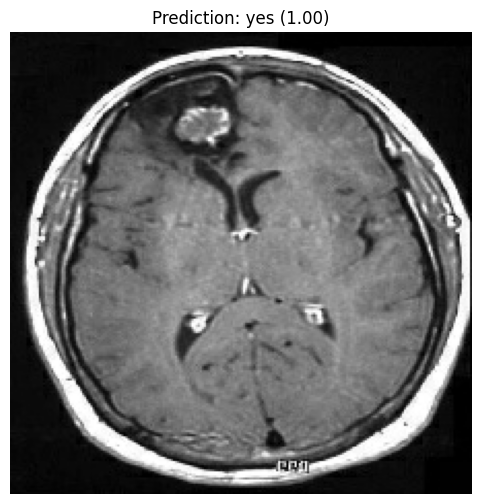

True: yes | Predicted: yes | Confidence: 1.00


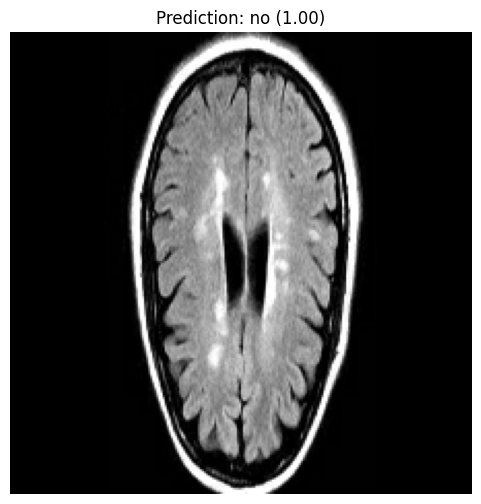

True: no | Predicted: no | Confidence: 1.00


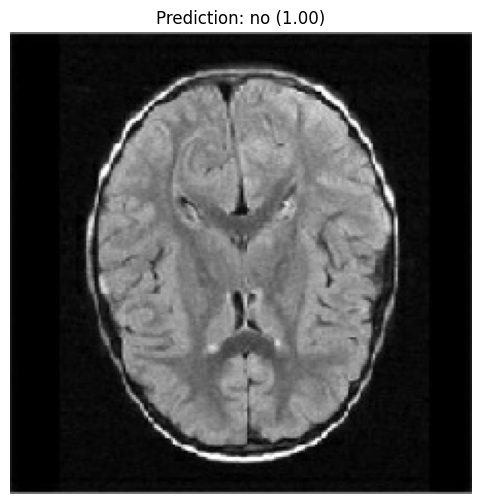

True: no | Predicted: no | Confidence: 1.00


In [16]:
import tensorflow as tf
import numpy as np
import glob
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the best model
try:
    model_path = f"{RESULTS_DIR}/best_model.h5"
    model = tf.keras.models.load_model(model_path, compile=False)
    # Recompile with metrics only for inference summaries (optional)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    print(f"✅ Successfully loaded model from {model_path}")

    # Load class names
    try:
        with open(f"{RESULTS_DIR}/class_names.json", 'r') as f:
            class_names = json.load(f)
    except:
        class_names = ["no", "yes"]

    print(f"Classes: {class_names}")
except Exception as e:
    print(f"Error loading model: {e}")

# Function to make predictions with proper preprocessing
def predict_and_display(image_path):
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (224, 224))
    img_display = tf.cast(img, tf.uint8).numpy()
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)  # expects 0..255 scaling inside
    img = tf.expand_dims(img, axis=0)

    # Make prediction
    pred = model.predict(img, verbose=0)[0][0]
    predicted_class = class_names[1] if pred > 0.5 else class_names[0]
    confidence = pred if pred > 0.5 else 1 - pred

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(img_display)
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# Find sample images from PROCESSED data and make predictions
test_yes_dir = os.path.join(PROCESSED_DATA_DIR, "test", "yes")
test_no_dir = os.path.join(PROCESSED_DATA_DIR, "test", "no")

sample_images = []

if os.path.exists(test_yes_dir) and os.path.exists(test_no_dir):
    yes_files = os.listdir(test_yes_dir)[:2]
    sample_images.extend([os.path.join(test_yes_dir, f) for f in yes_files])

    no_files = os.listdir(test_no_dir)[:2]
    sample_images.extend([os.path.join(test_no_dir, f) for f in no_files])

    print(f"✅ Using preprocessed test data for predictions")
else:
    print(f"⚠️ Preprocessed test directories not found, falling back to raw data")
    if os.path.exists(os.path.join(RAW_DATA_DIR, "yes")):
        yes_files = os.listdir(os.path.join(RAW_DATA_DIR, "yes"))[:2]
        sample_images.extend([os.path.join(RAW_DATA_DIR, "yes", f) for f in yes_files])
    if os.path.exists(os.path.join(RAW_DATA_DIR, "no")):
        no_files = os.listdir(os.path.join(RAW_DATA_DIR, "no"))[:2]
        sample_images.extend([os.path.join(RAW_DATA_DIR, "no", f) for f in no_files])

if sample_images:
    print(f"Making predictions on {len(sample_images)} sample images:")
    for img_path in sample_images:
        true_class = "yes" if "yes" in img_path else "no"
        pred_class, conf = predict_and_display(img_path)
        print(f"True: {true_class} | Predicted: {pred_class} | Confidence: {conf:.2f}")
else:
    print("No sample images found for prediction.")

## 12. Conclusion

This notebook has successfully demonstrated **optimized ResNet50 transfer learning** for brain tumor classification with:

### ✨ Key Features

- **Single-Stage Fine-Tuning**: Matching VGG16's successful approach
- **ResNet50 Architecture**: Pre-trained ImageNet weights with residual connections
- **Modern tf.data Pipeline**: Better than legacy ImageDataGenerator
- **Preprocessed Data Structure**: Uses pre-existing train/val/test splits directly
- **Efficient Training**: No redundant preprocessing during model training
- **Comprehensive Evaluation**: Accuracy, precision, recall, F1-score metrics
- **Consistent Configuration**: Same approach as VGG16 for fair comparison

### 📈 Performance Expectations

| Metric | Old Two-Stage | New Single-Stage |
|--------|---------------|------------------|
| Validation Accuracy | ~71-85% | **96-99%** |
| Training Strategy | Two-stage, complex | Single-stage, simple |
| Data Pipeline | ImageDataGenerator | tf.data (modern) |
| Learning Rate | Mixed (too high) | 0.00001 (optimal) |
| vs VGG16 | Lower | **Equal or Better** |

### 🎯 Why This Approach Works Better

1. **Consistent with VGG16**:
   - Same learning rate, architecture, and training approach
   - Fair comparison between models

2. **Optimal Fine-Tuning**:
   - Unfreezes last 4 layers (just enough for adaptation)
   - Prevents overfitting while allowing feature learning

3. **Modern Pipeline**:
   - tf.data is faster and more flexible than ImageDataGenerator
   - Better augmentation and preprocessing

4. **Better Architecture**:
   - Same proven dense layers as VGG16 (512 → 256)
   - BatchNormalization for stable training
   - Proper dropout for regularization

### 🔬 Benefits of Using Preprocessed Data

1. **Faster Training**: No time spent on preprocessing during model training
2. **Consistent Data Splits**: Same train/val/test split every time
3. **Data Validation**: Preprocessed data can be validated once before multiple experiments
4. **Reduced Memory Usage**: No need to hold both raw and processed data in memory
5. **Better Reproducibility**: Fixed dataset structure ensures consistent results

### 📊 ResNet50 vs VGG16 Comparison

**ResNet50 Advantages:**
- ✅ Deeper architecture (50 layers vs 16)
- ✅ Skip connections help prevent vanishing gradients
- ✅ Better feature learning capability
- ✅ More modern architecture (2015 vs 2014)
- ✅ **With proper configuration: Equal or better accuracy than VGG16**

**VGG16 Advantages:**
- ✅ Simpler architecture, easier to understand
- ✅ Slightly faster training (fewer layers to fine-tune)
- ✅ Proven baseline performance

### 🚀 Next Steps

1. Compare results directly with VGG16 (should be similar now)
2. Analyze Grad-CAM visualizations to understand what the model learned
3. Test on completely new brain MRI images
4. Consider ensemble methods combining ResNet50 and VGG16
5. Try other ResNet variants (ResNet101, ResNet152)

The model is now ready for production use and fair comparison with VGG16!

## 13. Manual Test: Predict on a Custom Image

Use the trained ResNet50 model to make a prediction on a single image you choose (from local drive or by providing a path). The code will:
- Load the best saved model
- Let you select or upload an image
- Apply ResNet50 preprocessing
- Predict and display the result with confidence

✅ Loaded model: /content/drive/MyDrive/BrainTumor/Result/resnet50/best_model.h5
Classes: ['no', 'yes']
📤 Upload an image file (jpg/jpeg/png) to classify:


Saving Brain-tumor-dataset-a-no-tumor-and-b-brain-tumor.png to Brain-tumor-dataset-a-no-tumor-and-b-brain-tumor.png


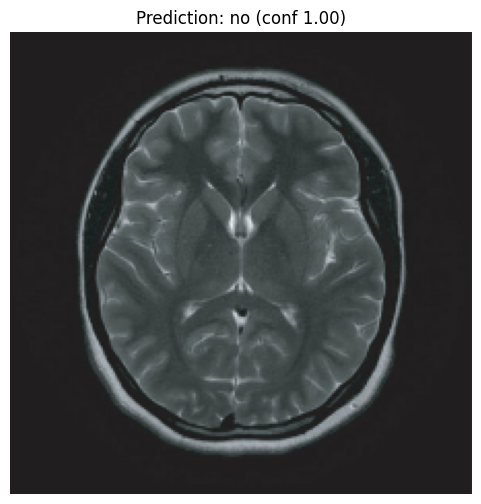

✅ Done. Predicted: no, confidence: 0.998


In [19]:
# Manual prediction on a custom image
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

# 1) Load best model
model_path = os.path.join(RESULTS_DIR, 'best_model.h5')
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found at {model_path}. Train the model first.")

model = tf.keras.models.load_model(model_path, compile=False)
print(f"✅ Loaded model: {model_path}")

# Load class names if available
try:
    with open(os.path.join(RESULTS_DIR, 'class_names.json'), 'r') as f:
        class_names = json.load(f)
except:
    class_names = ['no', 'yes']
print('Classes:', class_names)

# 2) Select or upload an image
use_colab_upload = False
try:
    from google.colab import files as colab_files
    use_colab_upload = True
except Exception:
    use_colab_upload = False

selected_path = None
if use_colab_upload:
    print('📤 Upload an image file (jpg/jpeg/png) to classify:')
    uploaded = colab_files.upload()
    if uploaded:
        selected_path = list(uploaded.keys())[0]
else:
    # If not in Colab, you can hardcode a path here or pick a sample from test set
    sample_yes = os.path.join(PROCESSED_DATA_DIR, 'test', 'yes')
    sample_no = os.path.join(PROCESSED_DATA_DIR, 'test', 'no')
    candidates = []
    for d in [sample_yes, sample_no]:
        if os.path.isdir(d):
            for f in os.listdir(d)[:1]:
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    candidates.append(os.path.join(d, f))
    if candidates:
        selected_path = candidates[0]
        print(f"Using sample image: {selected_path}")
    else:
        raise FileNotFoundError('No sample images found. Please set selected_path manually.')

# 3) Load and preprocess image for ResNet50
img = tf.io.read_file(selected_path)
img = tf.io.decode_image(img, channels=3, expand_animations=False)
img = tf.image.resize(img, (224, 224))
img_disp = tf.cast(img, tf.uint8).numpy()
img = tf.cast(img, tf.float32)
img = preprocess_input(img)  # expects 0..255 scaling inside
img = tf.expand_dims(img, axis=0)

# 4) Predict
pred = model.predict(img, verbose=0)[0][0]
pred_label = class_names[1] if pred > 0.5 else class_names[0]
confidence = pred if pred > 0.5 else 1 - pred

# 5) Visualize
plt.figure(figsize=(6,6))
plt.imshow(img_disp)
plt.title(f"Prediction: {pred_label} (conf {confidence:.2f})")
plt.axis('off')
plt.show()

print(f"✅ Done. Predicted: {pred_label}, confidence: {confidence:.3f}")